In [454]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from arch.univariate import arch_model
from pygam import LinearGAM,s
import numpy as np

In [455]:
directory = os.getcwd()
MSFT = pd.read_csv('MSFT.csv')
BA = pd.read_csv('BA.csv')
KO = pd.read_csv('KO.csv')
MSFT['date'][0] = '2019/01/23'
BA['date'][0] = '2019/01/23'
KO['date'][0] = '2019/01/23'

## change date column to datetime format
from datetime import datetime
MSFT['date'] = pd.to_datetime(MSFT['date'])
BA['date'] = pd.to_datetime(BA['date'])
KO['date'] = pd.to_datetime(KO['date'])


/Users/duguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/duguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/duguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [456]:
MSFT.head()

,date,close,volume,open,high,low
0,2019-01-23,106.71,"25,854,143",106.12,107.040,105.34
1,2019-01-22,105.68,32092050.0000,106.75,107.100,104.86
2,2019-01-18,107.71,37299850.0000,107.46,107.900,105.91
3,2019-01-17,106.12,27151570.0000,105.00,106.625,104.76
4,2019-01-16,105.38,29655860.0000,105.26,106.255,104.96


In [457]:
BA.head()

,date,close,volume,open,high,low
0,2019-01-23,358.61,"2,924,014",361.61,362.1995,353.67
1,2019-01-22,357.90,4333433.0000,362.86,364.1950,354.23
2,2019-01-18,364.73,4255247.0000,363.88,367.3156,361.32
3,2019-01-17,359.09,4257940.0000,350.75,363.8300,350.73
4,2019-01-16,352.06,2722590.0000,352.50,355.0000,351.56


In [458]:
KO.head()

,date,close,volume,open,high,low
0,2019-01-23,48.27,"12,053,987",47.60,48.2900,47.650
1,2019-01-22,47.72,11314410.0000,47.70,47.7900,47.205
2,2019-01-18,47.61,12760450.0000,47.25,47.6900,47.120
3,2019-01-17,47.06,11832680.0000,46.92,47.1385,46.880
4,2019-01-16,46.92,16797030.0000,47.40,47.4700,46.860


In [459]:
## I will analyze the close price of MSFT, BA and KO separately using ARIMA.
print('dimension of MSFT is:', MSFT.shape)
print('dimension of BA is:', BA.shape)
print('dimension of KO is:', KO.shape)

dimension of MSFT is: (253, 6)
dimension of BA is: (253, 6)
dimension of KO is: (253, 6)


# Method1 : Arima

## Microsoft

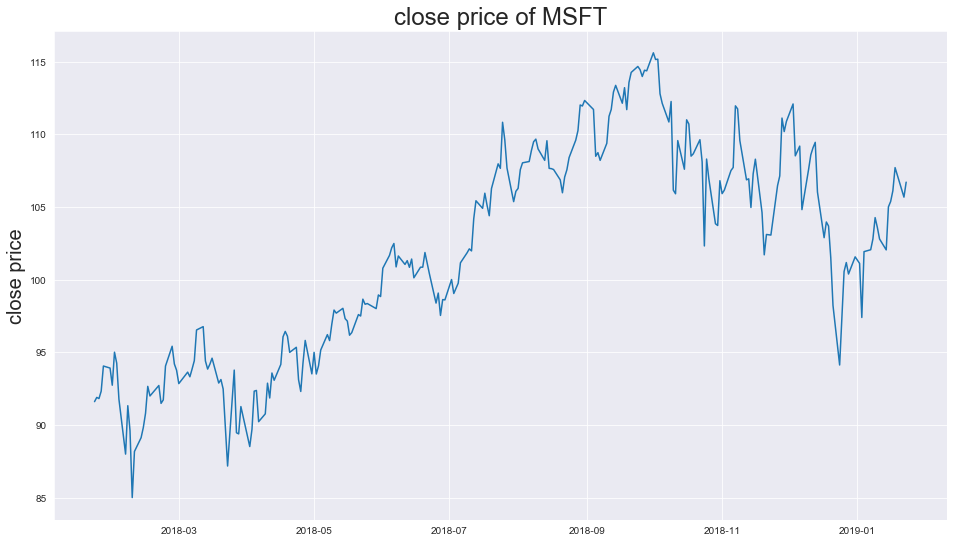

In [460]:
## First, I will analyze stock price of Microsoft.
## plot time series plot.
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(MSFT['date'], MSFT['close'])
ax.set_ylabel("close price", fontsize=20)
ax.set_title("close price of MSFT", fontsize=24)
plt.show()

# According to this time series plot, I find there is a trend that close price increases first and then decreases.
# So I think the time series is not stationary.

In [461]:
# I use adf test where p-value is 0.678. It means that this time series is not stationary.
from statsmodels.tsa.stattools import adfuller
result = adfuller(MSFT['close'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.188739
p-value: 0.678421


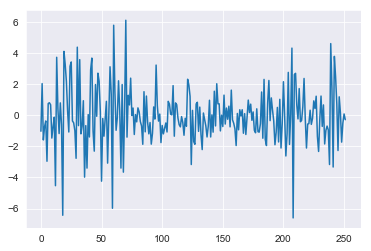

ADF Statistic: -14.053063
p-value: 0.000000


In [462]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
# create a differenced series
MSFT_diff = difference(MSFT['close'])
plt.plot(MSFT_diff)
plt.show()

# from the plot, I think it is stationary.
# I also implement adf-test on it. The p- value is 0, which means it is totally stationary.
result = adfuller(MSFT_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# Here we choose 'I' in ARIMA model to be 1.

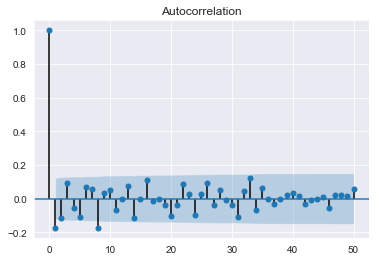

In [463]:
## plot acf
plot_acf(MSFT_diff, lags=50)
plt.show()
# from acf plot, I think it should be MA(1) or MA(2) model.

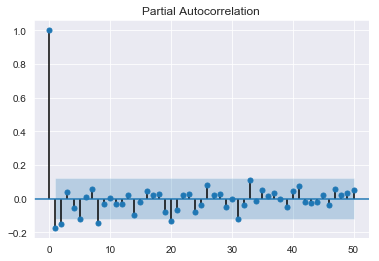

In [464]:
## plot pacf
plot_pacf(MSFT_diff, lags=50)
plt.show()
# from pacf plot, I think it is not a MA model, since th are many spikes after 1(such as lag8, lag20, lag 31)

In [465]:
# Here, I set a small range of p and q with the same difference of 1
# I hope to choose the best p and q from AIC and BIC.
for p in range(0,3):
    for q in range(0,3):
        model = ARIMA(MSFT['close'].values, order=(p,1,q))
        try:
            model_fit = model.fit(disp=0)
            print('ARIMA({},1,{}) with AIC:{}, BIC:{}'.format(p,q,model_fit.aic, model_fit.bic))
        except:
            continue

/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

ARIMA(0,1,0) with AIC:1021.1851783754818, BIC:1028.2440365505047
ARIMA(0,1,1) with AIC:1012.9504574593341, BIC:1023.5387447218684
ARIMA(0,1,2) with AIC:1011.9914863240795, BIC:1026.109202674125
ARIMA(1,1,0) with AIC:1015.4657866834452, BIC:1026.0540739459796
ARIMA(1,1,1) with AIC:1012.0404685100486, BIC:1026.1581848600943
ARIMA(1,1,2) with AIC:1013.2022068151898, BIC:1030.849352252747
ARIMA(2,1,0) with AIC:1011.5569274157774, BIC:1025.674643765823
ARIMA(2,1,1) with AIC:1013.0188847117444, BIC:1030.6660301493014


/Users/duguo/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/duguo/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/duguo/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/duguo/anaconda3/lib/python3.6/site-pack

>predicted=91.942287, true=92.330000
>predicted=92.192339, true=89.710000
>predicted=90.066495, true=88.520000
>predicted=88.692453, true=91.270000
>predicted=90.734802, true=89.390000
>predicted=89.553478, true=89.470000
>predicted=89.402697, true=93.780000
>predicted=92.899058, true=87.180000
>predicted=88.358675, true=89.790000
>predicted=89.377691, true=92.480000
>predicted=91.673702, true=93.130000
>predicted=92.735760, true=92.890000
>predicted=92.790468, true=94.600000
>predicted=94.130770, true=94.180000
>predicted=94.111165, true=93.850000
>predicted=93.850760, true=94.410000
>predicted=94.226024, true=96.770000
>predicted=96.148733, true=96.540000
>predicted=96.407111, true=94.430000
>predicted=94.825062, true=93.860000
>predicted=94.018956, true=93.320000
>predicted=93.416346, true=93.640000
>predicted=93.531901, true=93.050000
>predicted=93.097695, true=92.850000
>predicted=92.844477, true=93.770000
>predicted=93.505466, true=94.200000
>predicted=93.990270, true=95.420000
>

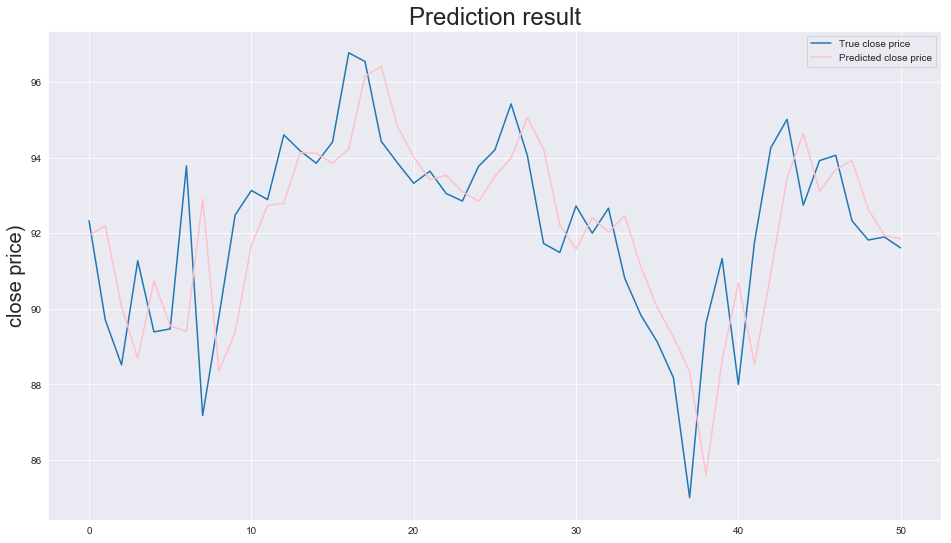

In [466]:
# Accoring to AIC and BIC, I choose ARIMA(0,1,1) model. This result is same as what I got from acf and pacf plot.
X = MSFT['close'].values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
## rolling forecast
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('>predicted=%f, true=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
## plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
x_pos = range(len(predictions))
ax.plot(x_pos, test, label="True close price")
ax.plot(x_pos, predictions, label="Predicted close price", c = 'pink')
ax.set_ylabel("close price)", fontsize=20)
ax.set_title("Prediction result", fontsize=24)
plt.legend()
plt.show()


In [467]:
stock_predicted_ARIMA = {}
# predict stock price of next ten days and save it.
model = ARIMA(X, order=(0,1,1))
model_fit = model.fit(disp=0)
output = model_fit.forecast(10)
stock_predicted_ARIMA['MSFT'] = output[0]

/Users/duguo/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/duguo/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/duguo/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/duguo/anaconda3/lib/python3.6/site-pack

## Boeing

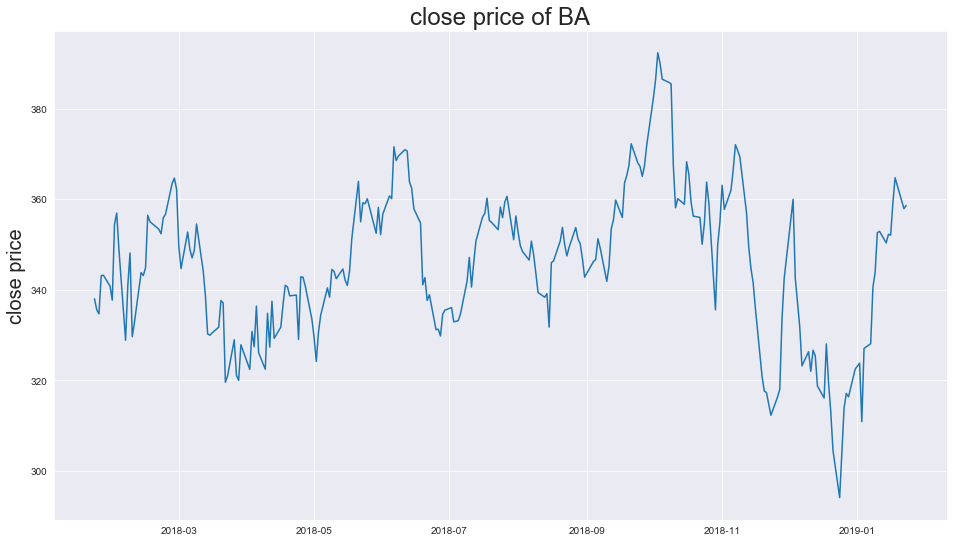

In [468]:
## First, I will analyze stock price of Boeing.
## plot time series plot.
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(BA['date'], BA['close'])
ax.set_ylabel("close price", fontsize=20)
ax.set_title("close price of BA", fontsize=24)
plt.show()

# According to this time series plot, I find the price approximately fluctuates near a horizontal line.
# So I think it is stationary.

In [469]:
# I use adf test where p-value is 0.012. It means that this time series is really stationary.
from statsmodels.tsa.stattools import adfuller
result = adfuller(BA['close'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.365558
p-value: 0.012191


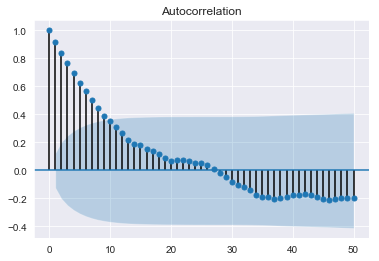

In [470]:
## plot acf
plot_acf(BA['close'], lags=50)
plt.show()
# from acf plot, I think it is not MA model.

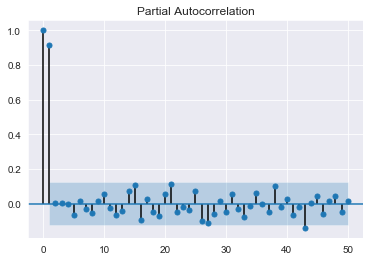

In [471]:
## plot pacf
plot_pacf(BA['close'], lags=50)
plt.show()
# from pacf plot, I think it is an AR(1) model.

In [472]:
# Here, I set a small range of p and q with the same difference of 0.
# I hope to choose the best p and q from AIC and BIC.
for p in range(0,3):
    for q in range(0,3):
        model = ARIMA(BA['close'].values, order=(p,0,q))
        try:
            model_fit = model.fit(disp=0)
            print('ARIMA({},0,{}) with AIC:{}, BIC:{}'.format(p,q,model_fit.aic, model_fit.bic))
        except:
            continue

/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

ARIMA(0,0,0) with AIC:2134.8586287941844, BIC:2141.9254077716396
ARIMA(0,0,1) with AIC:1924.126598373577, BIC:1934.7267668397596
ARIMA(0,0,2) with AIC:1815.9031928659174, BIC:1830.0367508208274
ARIMA(1,0,0) with AIC:1680.1785067513565, BIC:1690.778675217539
ARIMA(1,0,1) with AIC:1682.1623225668864, BIC:1696.2958805217963
ARIMA(1,0,2) with AIC:1684.1366377998474, BIC:1701.803585243485
ARIMA(2,0,0) with AIC:1682.1627117683106, BIC:1696.2962697232206
ARIMA(2,0,1) with AIC:1684.1579709733787, BIC:1701.8249184170163
ARIMA(2,0,2) with AIC:1686.1345088750672, BIC:1707.3348458074324


>predicted=337.204802, true=327.440000
>predicted=328.843995, true=330.820000
>predicted=331.993433, true=322.440000
>predicted=324.135426, true=327.880000


/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

>predicted=329.227508, true=320.020000
>predicted=321.832761, true=321.120000
>predicted=322.844333, true=328.970000
>predicted=330.209891, true=321.000000
>predicted=322.719006, true=319.610000
>predicted=321.382163, true=337.100000
>predicted=337.787237, true=337.630000
>predicted=338.276372, true=331.760000
>predicted=332.809220, true=330.470000
>predicted=331.597680, true=329.980000
>predicted=331.131131, true=330.260000
>predicted=331.383539, true=338.670000
>predicted=339.218513, true=344.190000
>predicted=344.345805, true=354.520000
>predicted=353.935452, true=348.730000
>predicted=348.560768, true=347.040000
>predicted=346.993652, true=348.920000
>predicted=348.737872, true=352.750000
>predicted=352.292779, true=344.670000
>predicted=344.798822, true=349.690000
>predicted=349.451585, true=362.210000
>predicted=361.068470, true=364.640000
>predicted=363.343059, true=363.480000
>predicted=362.272154, true=356.660000
>predicted=355.929994, true=355.920000
>predicted=355.246991, tr

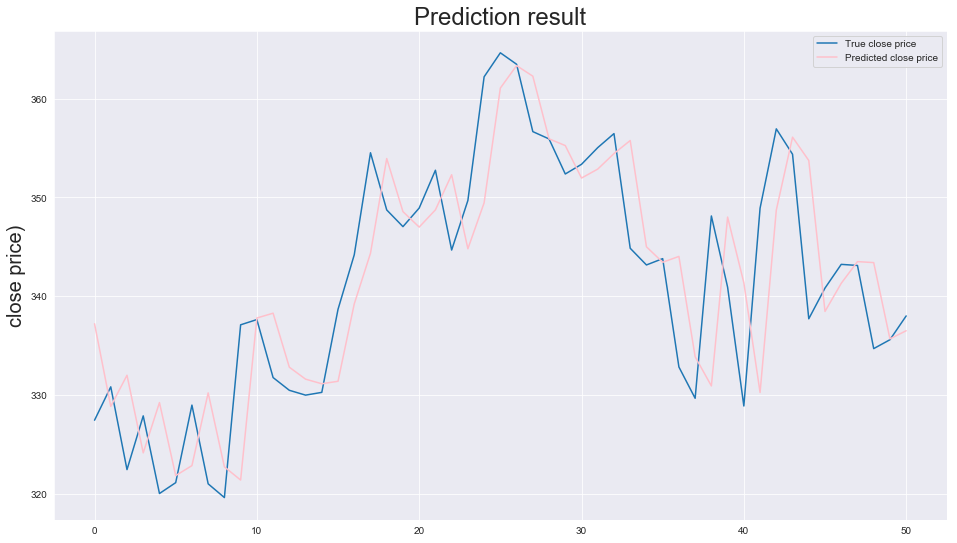

In [473]:
# Accoring to AIC and BIC, I choose ARMA(1,0) model. This result is same as what I got from acf and pacf plot.
X = BA['close'].values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
## rolling forecast
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('>predicted=%f, true=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
## plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
x_pos = range(len(predictions))
ax.plot(x_pos, test, label="True close price")
ax.plot(x_pos, predictions, label="Predicted close price", c = 'pink')
ax.set_ylabel("close price)", fontsize=20)
ax.set_title("Prediction result", fontsize=24)
plt.legend()
plt.show()


In [474]:
# predict stock price of next ten days and save it.
model = ARIMA(X, order=(1,0,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(10)
stock_predicted_ARIMA['BA'] = output[0]

/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

In [475]:
stock_predicted_ARIMA

{'BA': array([338.70662851, 339.35156888, 339.94020642, 340.47745634,
        340.96780474, 341.41534609, 341.8238174 , 342.19662947,
        342.53689532, 342.84745622]),
 'MSFT': array([91.60507333, 91.54589394, 91.48671456, 91.42753517, 91.36835579,
        91.3091764 , 91.24999702, 91.19081763, 91.13163825, 91.07245886])}

## Coca-Cola

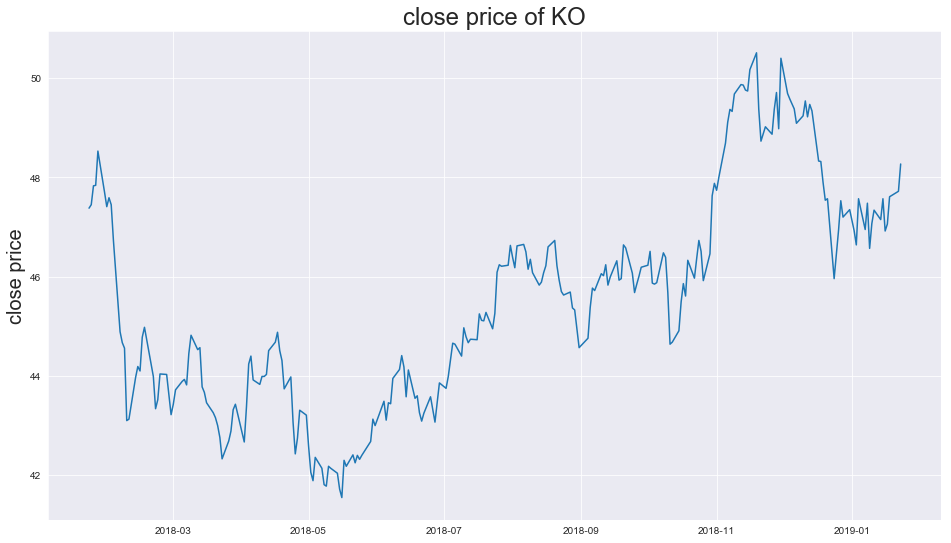

In [476]:
## First, I will analyze stock price of Boeing.
## plot time series plot.
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(KO['date'], KO['close'])
ax.set_ylabel("close price", fontsize=20)
ax.set_title("close price of KO", fontsize=24)
plt.show()

# According to this time series plot, I find the there is an increasing trend.
# So I think it is not stationary.

In [477]:
# I use adf test where p-value is 0.376. It means that this time series is not stationary.
from statsmodels.tsa.stattools import adfuller
result = adfuller(KO['close'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.808770
p-value: 0.376116


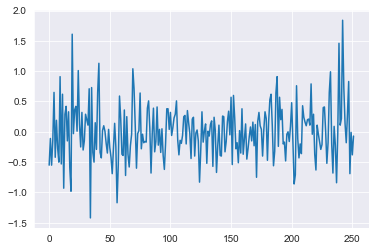

ADF Statistic: -12.477829
p-value: 0.000000


In [478]:
# create a differenced series
KO_diff = difference(KO['close'])
plt.plot(KO_diff)
plt.show()

# from the plot, I think it is stationary after taking a lag1 difference.
# I also implement adf-test on it. The p- value is 0, which means it is totally stationary.
result = adfuller(KO_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# Here we choose 'I' in ARIMA model to be 1.

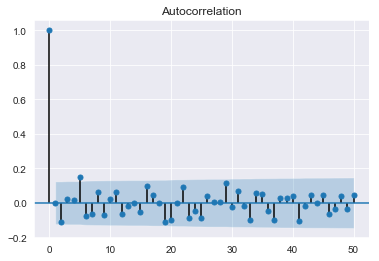

In [479]:
## plot acf
plot_acf(KO_diff, lags=50)
plt.show()
# from acf plot, I think it is MA(2) model.

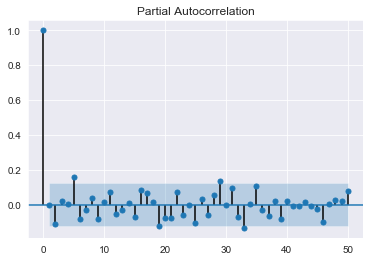

In [480]:
## plot pacf
plot_pacf(KO_diff, lags=50)
plt.show()
# from pacf plot, I think it is AR(2) model.

In [481]:
# Here, I set a small range of p and q with the same difference of 1
# I hope to choose the best p and q from AIC and BIC.
for p in range(0,3):
    for q in range(0,3):
        model = ARIMA(MSFT['close'].values, order=(p,1,q))
        try:
            model_fit = model.fit(disp=0)
            print('ARIMA({},1,{}) with AIC:{}, BIC:{}'.format(p,q,model_fit.aic, model_fit.bic))
        except:
            continue

/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

ARIMA(0,1,0) with AIC:1021.1851783754818, BIC:1028.2440365505047
ARIMA(0,1,1) with AIC:1012.9504574593341, BIC:1023.5387447218684
ARIMA(0,1,2) with AIC:1011.9914863240795, BIC:1026.109202674125
ARIMA(1,1,0) with AIC:1015.4657866834452, BIC:1026.0540739459796
ARIMA(1,1,1) with AIC:1012.0404685100486, BIC:1026.1581848600943
ARIMA(1,1,2) with AIC:1013.2022068151898, BIC:1030.849352252747
ARIMA(2,1,0) with AIC:1011.5569274157774, BIC:1025.674643765823
ARIMA(2,1,1) with AIC:1013.0188847117444, BIC:1030.6660301493014


/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

>predicted=44.429773, true=44.240000
>predicted=44.271908, true=43.380000
>predicted=43.423126, true=42.670000
>predicted=42.719658, true=43.430000
>predicted=43.472926, true=43.320000
>predicted=43.363792, true=42.890000
>predicted=42.937774, true=42.690000
>predicted=42.738931, true=42.330000
>predicted=42.380877, true=42.760000
>predicted=42.807703, true=43.000000
>predicted=43.045252, true=43.160000
>predicted=43.203338, true=43.260000
>predicted=43.301960, true=43.460000
>predicted=43.499483, true=43.670000
>predicted=43.706756, true=43.780000
>predicted=43.815151, true=44.570000
>predicted=44.594228, true=44.530000
>predicted=44.554726, true=44.820000
>predicted=44.840141, true=44.450000
>predicted=44.475849, true=43.820000
>predicted=43.854971, true=43.930000
>predicted=43.963283, true=43.890000
>predicted=43.923632, true=43.720000
>predicted=43.755695, true=43.430000
>predicted=43.469104, true=43.220000
>predicted=43.261225, true=43.620000
>predicted=43.656412, true=44.030000
>

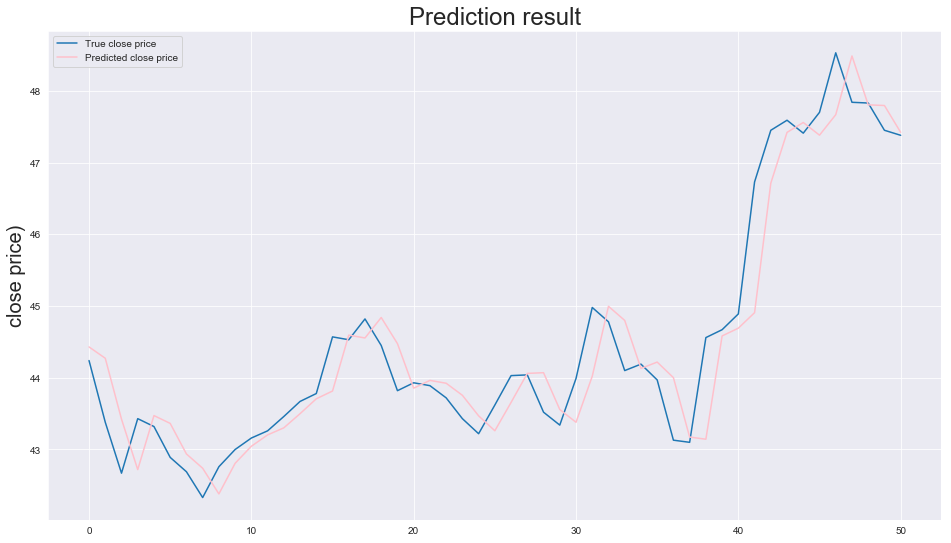

In [482]:
# Accoring to AIC and BIC, I choose ARIMA(2,1,0) model. 
X = KO['close'].values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
## rolling forecast
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('>predicted=%f, true=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
## plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
x_pos = range(len(predictions))
ax.plot(x_pos, test, label="True close price")
ax.plot(x_pos, predictions, label="Predicted close price", c = 'pink')
ax.set_ylabel("close price)", fontsize=20)
ax.set_title("Prediction result", fontsize=24)
plt.legend()
plt.show()


In [483]:
# predict stock price of next ten days and save it.
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(10)
stock_predicted_ARIMA['KO'] = output[0]

/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/duguo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

In [484]:
stock_predicted_ARIMA

{'BA': array([338.70662851, 339.35156888, 339.94020642, 340.47745634,
        340.96780474, 341.41534609, 341.8238174 , 342.19662947,
        342.53689532, 342.84745622]),
 'KO': array([47.41931728, 47.42355918, 47.41570226, 47.41181301, 47.40926249,
        47.40626327, 47.40311595, 47.40001937, 47.39693916, 47.39385322]),
 'MSFT': array([91.60507333, 91.54589394, 91.48671456, 91.42753517, 91.36835579,
        91.3091764 , 91.24999702, 91.19081763, 91.13163825, 91.07245886])}

#  Method2 : GAM

## Microsoft

In [499]:
## first I need to add more features to our model. I choose the past seven close price, their mean and their
## variance as features
col_names = ['date', 'close', 'mean_7', 'var_7']+['past' + str(i) for i in range(1,8)]
data_generalized = pd.DataFrame(columns=col_names)
X = MSFT['close'].values
date = MSFT['date'].values
for i in range(0, len(X) - 7):
    row = pd.DataFrame([[date[i], X[i], np.mean(X[i+1:i+8]), np.var(X[i+1:i+8])] + list(X[i+1:i+8])], columns=col_names)
    data_generalized = pd.concat([data_generalized, row], axis = 0)
    

In [501]:
data_generalized.head()


,date,close,mean_7,var_7,past1,past2,past3,past4,past5,past6,past7
0,2019-01-23,106.71,104.964286,3.248424,105.68,107.71,106.12,105.38,105.01,102.05,102.80
0,2019-01-22,105.68,104.667143,3.352849,107.71,106.12,105.38,105.01,102.05,102.80,103.60
0,2019-01-18,107.71,104.175714,1.811167,106.12,105.38,105.01,102.05,102.80,103.60,104.27
0,2019-01-17,106.12,103.701429,1.316555,105.38,105.01,102.05,102.80,103.60,104.27,102.80
0,2019-01-16,105.38,103.227143,1.073992,105.01,102.05,102.80,103.60,104.27,102.80,102.06


In [ ]:
## seperate the train and test set
X = data_generalized.iloc[:,1:]
y = data_generalized['close'].values
size = int(len(y) * 0.8)
train, test = X.iloc[0:size, :], X.iloc[size:, :]
y_train, y_test = y[0:size], y[size:]

## use train set to train GAM model.
gam = LinearGAM(s(0, n_splines=5) + s(1, n_splines=5) + s(2, n_splines=5)+s(3, n_splines=5)+s(4, n_splines=5)+\
                s(5, n_splines=5)+s(6, n_splines = 5) + s(7, n_splines = 5) + s(8, n_splines = 5)).fit(train,y_train)

## tune parameters
lam = np.logspace(-3, 3, 3)
lams = [lam] * 9
gam.gridsearch(train, y_train, lam=lams)
gam.summary()

## make predictions
predictions = gam.predict(test)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)

## plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
x_pos = range(len(predictions))
ax.plot(x_pos, y_test, label="True close price")
ax.plot(x_pos, predictions, label="Predicted close price", c = 'pink')
ax.set_ylabel("close price)", fontsize=20)
ax.set_title("Prediction result", fontsize=24)
plt.legend()
plt.show()


 15% (3095 of 19683) |##                 | Elapsed Time: 0:01:55 ETA:   0:09:55

In [487]:
stock_predicted_GAM = {}
## predict next ten days, and each time I use the predicted value as true past values.
history = list(MSFT['close'].values[:7])
pred_10 = []
for i in range(0, 10):
    pred = list(gam.predict([history[i:i+7]]))
    history+= pred
    pred_10+= pred
stock_predicted_GAM['MSFT'] = pred_10

## Boeing

In [488]:
## first I need to add more features to our model. I choose the past seven close price as features
col_names = ['date', 'close']+['past' + str(i) for i in range(1,8)]
data_generalized = pd.DataFrame(columns=col_names)
X = BA['close'].values
date = BA['date'].values
for i in range(0, len(X) - 7):
    row = pd.DataFrame([[date[i], X[i]] + list(X[i+1:i+8])], columns=col_names)
    data_generalized = pd.concat([data_generalized, row], axis = 0)
    

100% (2187 of 2187) |####################| Elapsed Time: 0:01:11 Time:  0:01:11
/Users/duguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  from ipykernel import kernelapp as app


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.0062
Link Function:                     IdentityLink Log Likelihood:                                  -907.6634
Number of Samples:                          196 AIC:                                             1833.3391
                                                AICc:                                            1834.3081
                                                GCV:                                               43.6503
                                                Scale:                                              40.453
                                                Pseudo R-Squared:                                   0.8662
Feature Function                  Lam

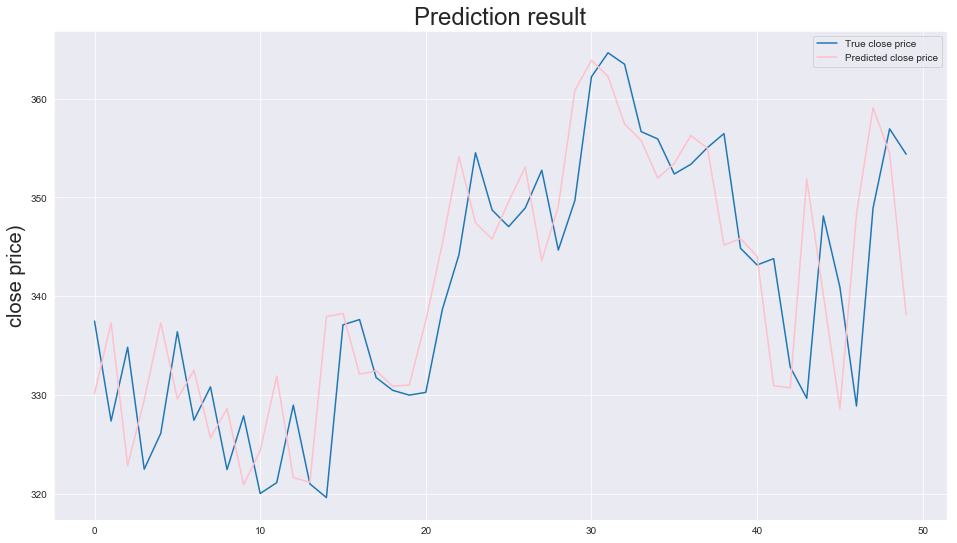

In [489]:
## seperate the train and test set
X = data_generalized.iloc[:, -7:]
y = data_generalized['close'].values
size = int(len(y) * 0.8)
train, test = X.iloc[0:size, :], X.iloc[size:, :]
y_train, y_test = y[0:size], y[size:]

## use train set to train GAM model.
gam = LinearGAM(s(0, n_splines=5) + s(1, n_splines=5) + s(2, n_splines=5)+s(3, n_splines=5)+\
                s(4, n_splines=5)+s(5, n_splines=5)+s(6, n_splines = 5)).fit(train,y_train)

## tune parameters
lam = np.logspace(-3, 3, 3)
lams = [lam] * 7
gam.gridsearch(train, y_train, lam=lams)
gam.summary()

## make predictions
predictions = gam.predict(test)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)

## plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
x_pos = range(len(predictions))
ax.plot(x_pos, y_test, label="True close price")
ax.plot(x_pos, predictions, label="Predicted close price", c = 'pink')
ax.set_ylabel("close price)", fontsize=20)
ax.set_title("Prediction result", fontsize=24)
plt.legend()
plt.show()


In [490]:
## predict next ten days, and each time I use the predicted value as true past values.
history = list(BA['close'].values[:7])
pred_10 = []
for i in range(0, 10):
    pred = list(gam.predict([history[i:i+7]]))
    history+= pred
    pred_10+= pred
stock_predicted_GAM['BA'] = pred_10

In [491]:
stock_predicted_GAM

{'BA': [357.07528221500536,
  356.61178138053504,
  364.2555699916359,
  357.559667402237,
  352.53318174115594,
  351.69861136613434,
  350.3941403317699,
  355.4846435485302,
  355.7269941973342,
  363.5807015533153],
 'MSFT': [106.69274964007283,
  105.40874372102192,
  107.56778658658051,
  106.21695745396221,
  105.35707966724291,
  105.09786103322728,
  102.66182047282147,
  106.63176210043135,
  105.26804584250472,
  107.44997311559057]}

## Coca-Cola

In [492]:
## first I need to add more features to our model. I choose the past seven close price as features
col_names = ['date', 'close']+['past' + str(i) for i in range(1,8)]
data_generalized = pd.DataFrame(columns=col_names)
X = KO['close'].values
date = KO['date'].values
for i in range(0, len(X) - 7):
    row = pd.DataFrame([[date[i], X[i]] + list(X[i+1:i+8])], columns=col_names)
    data_generalized = pd.concat([data_generalized, row], axis = 0)
    

100% (2187 of 2187) |####################| Elapsed Time: 0:01:10 Time:  0:01:10
/Users/duguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  from ipykernel import kernelapp as app


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.0143
Link Function:                     IdentityLink Log Likelihood:                                  -367.3701
Number of Samples:                          196 AIC:                                              752.7688
                                                AICc:                                             753.7396
                                                GCV:                                                0.1935
                                                Scale:                                              0.1794
                                                Pseudo R-Squared:                                   0.9645
Feature Function                  Lam

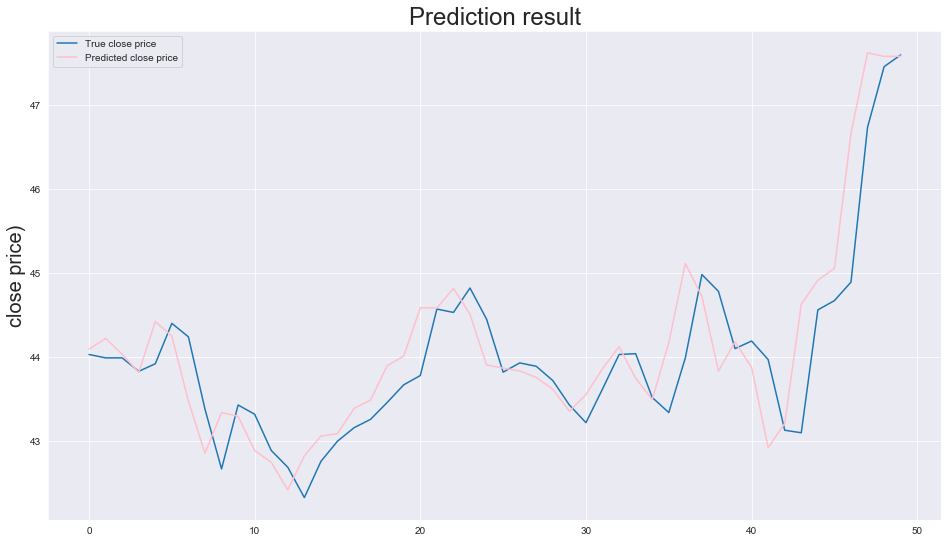

In [493]:
## seperate the train and test set
X = data_generalized.iloc[:, -7:]
y = data_generalized['close'].values
size = int(len(y) * 0.8)
train, test = X.iloc[0:size, :], X.iloc[size:, :]
y_train, y_test = y[0:size], y[size:]

## use train set to train GAM model.
gam = LinearGAM(s(0, n_splines=5) + s(1, n_splines=5) + s(2, n_splines=5)+s(3, n_splines=5)+\
                s(4, n_splines=5)+s(5, n_splines=5)+s(6, n_splines = 5)).fit(train,y_train)

## tune parameters
lam = np.logspace(-3, 3, 3)
lams = [lam] * 7
gam.gridsearch(train, y_train, lam=lams)
gam.summary()

## make predictions
predictions = gam.predict(test)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)

## plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
x_pos = range(len(predictions))
ax.plot(x_pos, y_test, label="True close price")
ax.plot(x_pos, predictions, label="Predicted close price", c = 'pink')
ax.set_ylabel("close price)", fontsize=20)
ax.set_title("Prediction result", fontsize=24)
plt.legend()
plt.show()


In [494]:
## predict next ten days, and each time I use the predicted value as true past values.
history = list(KO['close'].values[:7])
pred_10 = []
for i in range(0, 10):
    pred = list(gam.predict([history[i:i+7]]))
    history+= pred
    pred_10+= pred
stock_predicted_GAM['KO'] = pred_10

In [495]:
stock_predicted_GAM

{'BA': [357.07528221500536,
  356.61178138053504,
  364.2555699916359,
  357.559667402237,
  352.53318174115594,
  351.69861136613434,
  350.3941403317699,
  355.4846435485302,
  355.7269941973342,
  363.5807015533153],
 'KO': [48.06249887666118,
  47.752382326300356,
  47.34325889347129,
  47.206333622825184,
  47.01695275518567,
  47.61665600230385,
  47.22273313351971,
  47.86203010062825,
  47.79014133009233,
  47.164781516185144],
 'MSFT': [106.69274964007283,
  105.40874372102192,
  107.56778658658051,
  106.21695745396221,
  105.35707966724291,
  105.09786103322728,
  102.66182047282147,
  106.63176210043135,
  105.26804584250472,
  107.44997311559057]}

In [496]:
stock_predicted_ARIMA

{'BA': array([338.70662851, 339.35156888, 339.94020642, 340.47745634,
        340.96780474, 341.41534609, 341.8238174 , 342.19662947,
        342.53689532, 342.84745622]),
 'KO': array([47.41931728, 47.42355918, 47.41570226, 47.41181301, 47.40926249,
        47.40626327, 47.40311595, 47.40001937, 47.39693916, 47.39385322]),
 'MSFT': array([91.60507333, 91.54589394, 91.48671456, 91.42753517, 91.36835579,
        91.3091764 , 91.24999702, 91.19081763, 91.13163825, 91.07245886])}

In [498]:
np.mean([1,2,3])

2.0